In [1]:
from torch.utils.data import DataLoader
import torch.nn.functional  as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch
import math
import cv2
import os

In [ ]:
device = torch.device("mps")
IMG_SIZE = 448 # 448 est peut etre la meilleur taille pour l'instant mais 896 fait le taffe également

In [3]:
"""
Architecture:
Input: RGB screenshot (HxWx3) ou grayscale
→ CNN (3-4 conv blocks avec ReLU, BN, MaxPool)
→ Flatten
→ MLP (2-3 couches fully connected)
→ Output: [x_norm, y_norm]  ∈ [0, 1]^2
"""

'\nArchitecture:\nInput: RGB screenshot (HxWx3) ou grayscale\n→ CNN (3-4 conv blocks avec ReLU, BN, MaxPool)\n→ Flatten\n→ MLP (2-3 couches fully connected)\n→ Output: [x_norm, y_norm]  ∈ [0, 1]^2\n'

In [4]:
class MouseNet(nn.Module):
    def __init__(self, in_channels, num_classes, input_size=IMG_SIZE):
        super(MouseNet, self).__init__()
        self.input_size = input_size
        
        # Couches convolutionnelles
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Calcul de la taille après convolutions
        # input_size -> /2 -> /2 = input_size // 4
        self.feature_size = self._get_conv_output_size(in_channels, input_size)
        
        # Couches fully connected
        self.fc1 = nn.Linear(self.feature_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.out = nn.Linear(128, num_classes)
        
    def _get_conv_output_size(self, in_channels, input_size):
        """Calcule la taille de sortie des couches convolutionnelles"""
        # Simulation d'un passage dans les conv layers
        x = torch.randn(1, in_channels, input_size, input_size)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        return x.view(1, -1).size(1)

    def forward(self, x):
        # x shape attendue: (batch_size, in_channels, height, width)
        batch_size = x.size(0)
        
        # Couches convolutionnelles
        x = F.relu(self.conv1(x))  # (batch, 8, H, W)
        x = self.pool(x)           # (batch, 8, H/2, W/2)
        x = F.relu(self.conv2(x))  # (batch, 16, H/2, W/2)
        x = self.pool(x)           # (batch, 16, H/4, W/4)
        x = F.relu(self.conv3(x))  # (batch, 32, H/4, W/4)
        
        # Aplatissement pour les couches fully connected
        x = x.view(batch_size, -1)  # (batch, 32 * H/4 * W/4)
        
        # Couches fully connected
        x = F.relu(self.fc1(x))    # (batch, 64)
        x = F.relu(self.fc2(x))    # (batch, 128)
        x = self.out(x)            # (batch, num_classes)
        return torch.sigmoid(x).to(torch.float32)

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, vec_output, vec_target):
        """
        Ce loss calcule la distance euclidienne entre deux vecteurs: dist = (tensor1 - tensor2).pow(2).sum().sqrt()
        """
        return torch.linalg.vector_norm(vec_output - vec_target)


In [6]:
l = CustomLoss()
ten1 = torch.tensor((0.6, 0.6))
ten2 = torch.tensor((0.7, 0.5))
dist = l(ten1, ten2)
print("distance :", dist)

distance : tensor(0.1414)


In [7]:
# Load image in grayscale
path = "/Users/ibrahimbaldediallo/Documents/Code/Jarvis_project/TD/image.png"
# 1. Charger l'image en niveaux de gris (1 canal)
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# 2. Prétraitement
blur = cv2.GaussianBlur(img, (5, 5), 1.4)
edges = cv2.Canny(blur, threshold1=100, threshold2=200)  # Utiliser blur pour de meilleurs résultats
edges = cv2.resize(edges, (IMG_SIZE, IMG_SIZE))  # Taille attendue par MouseNet (64x64)

# 3. Ajouter les dimensions manquantes
# - Convertir en float32 et normaliser [0, 255] -> [0, 1]
edges = edges.astype(np.float32) / 255.0

# - Ajouter les dimensions: [Hauteur, Largeur] -> [Canaux, Hauteur, Largeur]
edges = np.expand_dims(edges, axis=0)  # Maintenant shape (1, 64, 64)
 
#cv2.waitKey(0)
#cv2.destroyAllWindows()
inputs = torch.tensor(edges, dtype=torch.float32).unsqueeze(0).to(device)

In [8]:
model = MouseNet(in_channels=1, num_classes=2, input_size=IMG_SIZE).to(device)

In [9]:

print(inputs.shape)
y = model(inputs)
print(y)
for batch_size in [1, 16]:
    dummy_input = torch.randn(batch_size, 1, IMG_SIZE, IMG_SIZE).to(device)
    output = model(dummy_input)
    print(f"Batch {batch_size}: Output shape {output.shape}")
    print(output)
    
    # Vérification des valeurs de sortie
    assert torch.all(output >= 0) and torch.all(output <= 1)  # Sigmoïde bien appliqué
    assert not torch.isnan(output).any()  # Pas de NaNs

torch.Size([1, 1, 448, 448])
tensor([[0.5068, 0.5354]], device='mps:0', grad_fn=<SigmoidBackward0>)
Batch 1: Output shape torch.Size([1, 2])
tensor([[0.5067, 0.5357]], device='mps:0', grad_fn=<SigmoidBackward0>)
Batch 16: Output shape torch.Size([16, 2])
tensor([[0.5073, 0.5351],
        [0.5089, 0.5359],
        [0.5079, 0.5345],
        [0.5100, 0.5359],
        [0.5071, 0.5354],
        [0.5063, 0.5354],
        [0.5079, 0.5361],
        [0.5082, 0.5346],
        [0.5073, 0.5353],
        [0.5077, 0.5353],
        [0.5089, 0.5360],
        [0.5080, 0.5358],
        [0.5078, 0.5363],
        [0.5064, 0.5361],
        [0.5078, 0.5352],
        [0.5086, 0.5363]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [10]:
def preprocess_image(img_path, img_size=(IMG_SIZE, IMG_SIZE)):
    # Chargement en niveaux de gris
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Flou pour éliminer le bruit
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Détection de bords Canny
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    
    # Convertir en 3 canaux pour CNN (shape HxWx3)
    #edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    
    # Resize
    resized = cv2.resize(edges, img_size)


    blur = cv2.GaussianBlur(img, (5, 5), 1.4)
    target = cv2.Canny(blur, threshold1=100, threshold2=200)  # Utiliser blur pour de meilleurs résultats
    target = cv2.resize(target, img_size)  # Taille attendue par MouseNet (224x224)

    # 3. Ajouter les dimensions manquantes
    # - Convertir en float32 et normaliser [0, 255] -> [0, 1]
    target = target.astype(np.float32) / 255.0

    # - Ajouter les dimensions: [Hauteur, Largeur] -> [Canaux, Hauteur, Largeur]
    target = np.expand_dims(target, axis=0)  # Maintenant shape (1, 224, 224)

    
    return target, resized, img.shape[:2]  # image filtrée, taille originale

def create_dataset_from_images(image_paths, min_area=500):
    dataset = []

    for path in image_paths:
        # Prétraitement (filtre Canny)
        target, filtered_img, (orig_h, orig_w) = preprocess_image(path)

        # Extraction des contours
        contours, _ = cv2.findContours(cv2.Canny(filtered_img, 50, 150), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_area:
                continue  # On ignore les petits éléments non pertinents

            # Bounding box
            x, y, w, h = cv2.boundingRect(cnt)
            center_x = x + w // 2
            center_y = y + h // 2

            # Normalisation
            norm_x = center_x / orig_w
            norm_y = center_y / orig_h

            dataset.append((
                torch.tensor(target, dtype=torch.float32),
                torch.tensor((norm_x, norm_y), dtype=torch.float32)
            ))

    return dataset

In [11]:

image_paths = []
path = "/Users/ibrahimbaldediallo/Documents/Code/Jarvis_project/img_dataset"
for item in os.listdir(path):
    image_paths.append(path+"/"+item)


dataset = create_dataset_from_images(image_paths)

In [12]:
print(len(dataset))

223


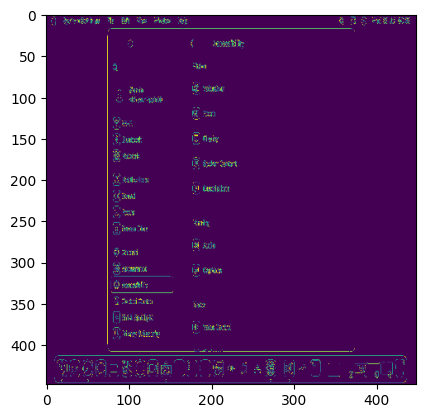

Image 1 → Pos: (0.03, 0.17)


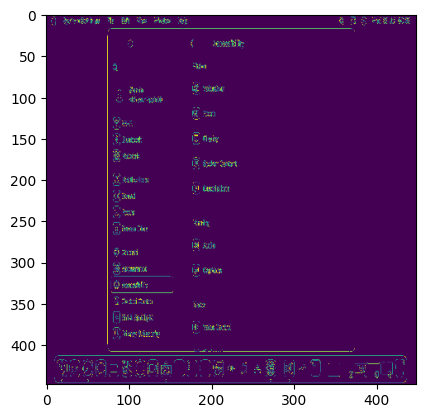

Image 2 → Pos: (0.10, 0.01)


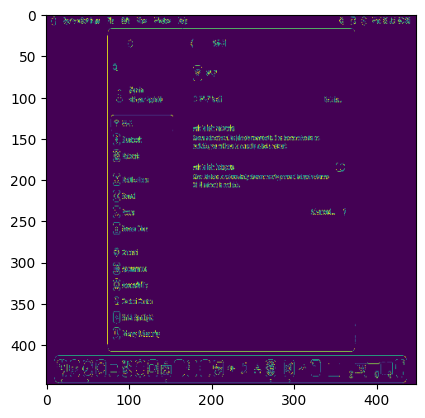

Image 3 → Pos: (0.10, 0.35)


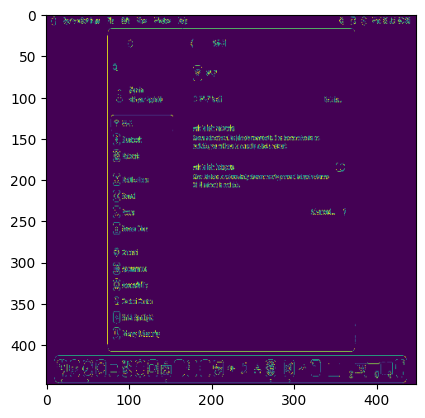

Image 4 → Pos: (0.10, 0.32)


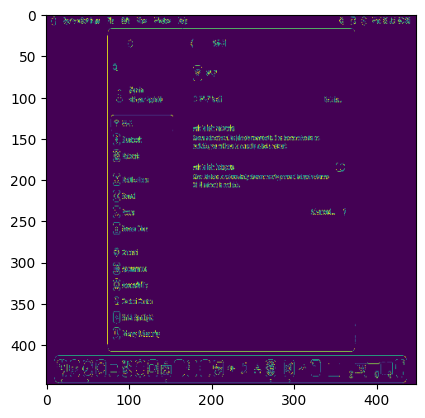

Image 5 → Pos: (0.17, 0.16)


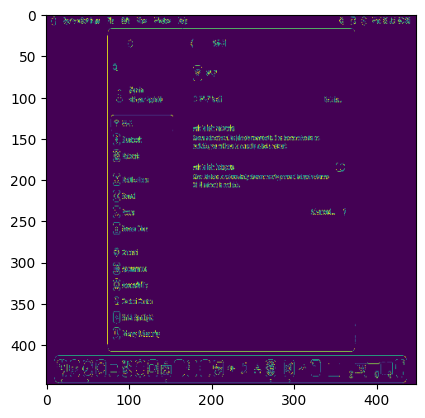

Image 6 → Pos: (0.03, 0.17)


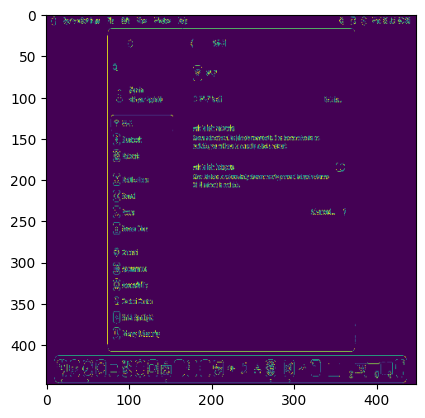

Image 7 → Pos: (0.10, 0.01)


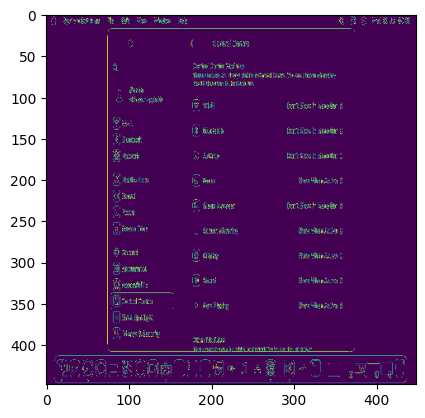

Image 8 → Pos: (0.10, 0.35)


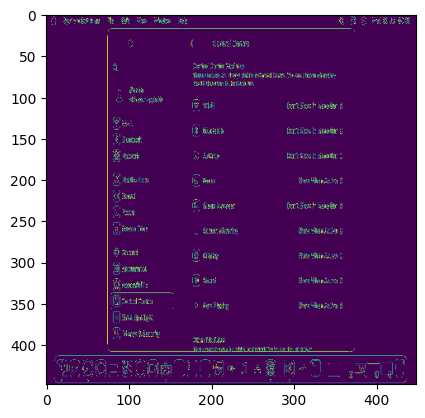

Image 9 → Pos: (0.03, 0.17)


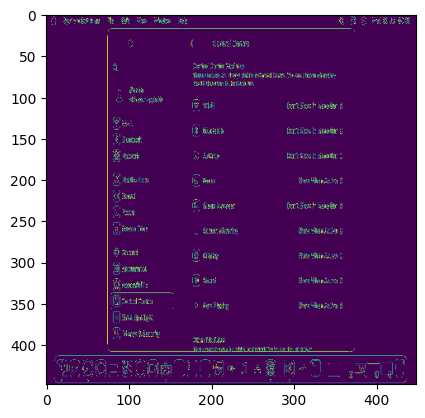

Image 10 → Pos: (0.10, 0.01)


In [13]:
for i, (img, (x, y)) in enumerate(dataset[-10:]):
    plt.imshow(img.squeeze(0))
    plt.show()
    print(f"Image {i+1} → Pos: ({x:.2f}, {y:.2f})")

In [14]:
# Define the loss function
criterion = CustomLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the dataloader
train_dataset = DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
for batch_index, (data, targets) in enumerate(tqdm(train_dataset)):

    print(targets.shape)
    print(data.shape)
    break

  0%|          | 0/28 [00:00<?, ?it/s]

torch.Size([8, 2])
torch.Size([8, 1, 448, 448])


Epoch [1/10]


100%|██████████| 28/28 [00:02<00:00, 12.37it/s]


Epoch [2/10]


100%|██████████| 28/28 [00:01<00:00, 20.17it/s]


Epoch [3/10]


100%|██████████| 28/28 [00:01<00:00, 20.19it/s]


Epoch [4/10]


100%|██████████| 28/28 [00:01<00:00, 20.22it/s]


Epoch [5/10]


100%|██████████| 28/28 [00:01<00:00, 20.13it/s]


Epoch [6/10]


100%|██████████| 28/28 [00:01<00:00, 20.16it/s]


Epoch [7/10]


100%|██████████| 28/28 [00:01<00:00, 19.65it/s]


Epoch [8/10]


100%|██████████| 28/28 [00:01<00:00, 20.06it/s]


Epoch [9/10]


100%|██████████| 28/28 [00:01<00:00, 20.05it/s]


Epoch [10/10]


100%|██████████| 28/28 [00:01<00:00, 20.13it/s]


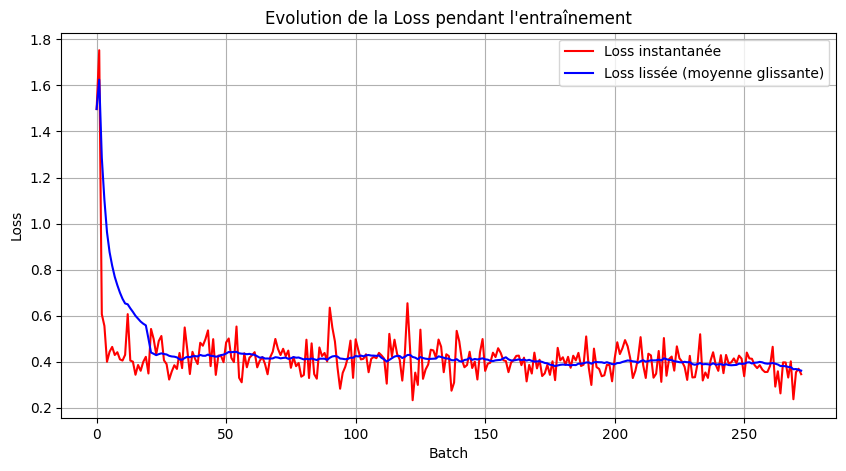

In [16]:
# Configuration de la visualisation
plt.ion()  # Mode interactif
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Evolution de la Loss pendant l\'entraînement')
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
line, = ax.plot([], [], 'r-', label='Loss instantanée')
smooth_line, = ax.plot([], [], 'b-', label='Loss lissée (moyenne glissante)')
ax.legend()
ax.grid(True)

# Paramètres
num_epochs = 10
window_size = 20  # Taille de la fenêtre pour le lissage
loss_list = []
smooth_loss = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    for batch_index, (data, targets) in enumerate(tqdm(train_dataset)):
        # Forward/Backward pass
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        loss = criterion(output, targets)
        
        # Mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stockage et visualisation
        loss_list.append(loss.item())
        
        # Calcul de la moyenne glissante
        if len(loss_list) >= window_size:
            smooth_loss.append(np.mean(loss_list[-window_size:]))
        else:
            smooth_loss.append(np.mean(loss_list))
        
        # Mise à jour dynamique du graphique
        if batch_index % 10 == 0:  # Toutes les 10 itérations
            x_data = np.arange(len(loss_list))
            line.set_data(x_data, loss_list)
            smooth_line.set_data(x_data, smooth_loss)
            ax.relim()
            ax.autoscale_view()
            fig.canvas.draw()
            fig.canvas.flush_events()
            
    # Sauvegarde périodique
    plt.savefig(f'loss_epoch_{epoch+1}.png')

# Désactivation du mode interactif et affichage final
plt.ioff()
plt.show()

# Sauvegarde des données de loss
np.save('loss_history.npy', np.array(loss_list))
np.save('smooth_loss.npy', np.array(smooth_loss))

In [17]:
torch.save(model.state_dict(), 'mousse_net.pth')